In [1]:
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVR, SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
# color dict (use: colors['XColor'])

colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

# set params
# save as .mplstyle file and import with: plt.style.use('file')
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.color'] = 'r'

# colors for seaborn
dark = ["#8c510a", "#01665e", "#762a83"]
med = ["#d8b365", "#5ab4ac", "#af8dc3"]

# Make Predictions wrt Error

In [3]:
train = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
trainXY = pd.read_pickle(train)

In [4]:
def add_error(percent_err, df):
    """
    Given a dataframe of nuclide vectors, add error to each element in each 
    nuclide vector that has a random value within the range [1-err, 1+err]

    Parameters
    ----------
    percent_err : a float indicating the maximum error that can be added to the nuclide 
                  vectors
    df : dataframe of only nuclide concentrations

    Returns
    -------
    df_err : dataframe with nuclide concentrations altered by some error

    """
    x = df.shape[0]
    y = df.shape[1]
    err = percent_err / 100.0
    low = 1 - err
    high = 1 + err
    errs = np.random.uniform(low, high, (x, y))
    df_err = df * errs
    df_err_scaled = scale(df_err)
    
    return df_err

In [5]:
def random_error(X, Y, alg1, alg2, alg3, scores, CV, csv_name):
    """
    """

    #err_percent = np.arange(0, 9.25, 0.25)
    err_percent = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 
                   1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 
                   2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.5, 6, 
                   6.5, 7, 7.5, 8, 8.5, 9, 10, 13, 17, 20]
    knn_mean = []
    knn_std = []
    dtr_mean = []
    dtr_std = []
    svr_mean = []
    svr_std = []
    for err in err_percent:
        
        X = add_error(err, X)
        X = scale(X)
    
        knn_scr = cross_val_score(alg1, X, Y, scoring=scores, cv=CV, n_jobs=-1)
        knn_mean.append(knn_scr.mean()) #train_mean = np.mean(train, axis=1)
        knn_std.append(knn_scr.std())
    
        dtr_scr = cross_val_score(alg2, X, Y, scoring=scores, cv=CV, n_jobs=-1)
        dtr_mean.append(dtr_scr.mean())
        dtr_std.append(dtr_scr.std())
        
        svr_scr = cross_val_score(alg3, X, Y, scoring=scores, cv=CV, n_jobs=-1)
        svr_mean.append(svr_scr.mean())
        svr_std.append(svr_scr.std())
    
    df = pd.DataFrame({'Percent Error' : err_percent, 
                       'kNN Score' : knn_mean, 'kNN Std' : knn_std, 
                       'DTree Score' : dtr_mean, 'DTree Std' : dtr_std, 
                       'SVR Score' : svr_mean, 'SVR Std' : svr_std,}, index=err_percent)
    df.to_csv(csv_name + '_random-error.csv')

In [6]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    if 'total' in dfX.columns:
        dfX.drop('total', axis=1, inplace=True)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    #o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY

trainXY.reset_index(inplace=True, drop=True)
trainXY = trainXY.sample(frac=0.6)
trainX, rY, cY, eY, bY = splitXY(trainXY)
#trainX = scale(trainX)

In [8]:
CV=5
for Y in ('c',):
    trainY = pd.Series()
    # get param names and set ground truth
    if Y == 'b':
        # burnup needs much less training data...this is 24% of data set
        trainXY = trainXY.sample(frac=0.4)
        trainX, rY, cY, eY, bY = splitXY(trainXY)
        #trainX = scale(trainX)
        trainY = bY
        parameter = 'burnup'
        k = 7
        depth = 20
        feats = 15
        g = 0.1
        c = 1500
    elif Y == 'c':
        trainY = cY
        parameter = 'cooling'
        k = 3
        depth = 20
        feats = 15
        g = 0.1
        c = 1500
    else:
        trainY = rY
        parameter = 'reactor'    
        k = 1
        depth = 20
        feats = 15
        g = 0.1
        c = 1500
        
    csv_name = '15nuc_m60_scale-last_' + parameter
        
    ## initialize learners
    score = 'explained_variance'
    kfold = KFold(n_splits=CV, shuffle=True)
    knn_init = KNeighborsRegressor(n_neighbors=k, weights='distance')
    dtr_init = DecisionTreeRegressor(max_depth=depth, max_features=feats)
    svr_init = SVR(gamma=g, C=c)
    if Y == 'r':
        score = 'accuracy'
        kfold = StratifiedKFold(n_splits=CV, shuffle=True)
        knn_init = KNeighborsClassifier(n_neighbors=k, weights='distance')
        dtr_init = DecisionTreeClassifier(max_depth=depth, max_features=feats, class_weight='balanced')
        svr_init = SVC(gamma=g, C=c, class_weight='balanced')

    #plt.figure()
    #dtree = dtr_init.fit(trainX, trainY)
    #plot_tree(dtree) 
    #plt.show()
    #plt.clf()
        
    random_error(trainX, trainY, knn_init, dtr_init, svr_init, score, CV, csv_name)

In [3]:
burn = pd.read_csv('../results/19jan2020_15nuc/15nuc_m60_scale-last_burnup_random-error.csv')
rxtr = pd.read_csv('../results/19jan2020_15nuc/15nuc_m60_scale-last_reactor_random-error.csv')
cool = pd.read_csv('../results/19jan2020_15nuc/15nuc_m60_scale-last_cooling_random-error.csv')
cool.head()

,Unnamed: 0,Percent Error,kNN Score,kNN Std,DTree Score,DTree Std,SVR Score,SVR Std
0,0.0,0.0,0.885149,0.009711,0.990545,0.002177,0.848855,0.016639
1,0.1,0.1,0.884361,0.008851,0.977476,0.004220,0.848751,0.016706
2,0.2,0.2,0.881194,0.008524,0.969388,0.002766,0.848525,0.016698
3,0.3,0.3,0.875988,0.007980,0.950292,0.006288,0.847524,0.016654
4,0.4,0.4,0.871041,0.006112,0.934216,0.012932,0.846379,0.017014


In [11]:
def plot_errorcurves(df):
    
    plt.clf()
    
    err = df['Percent Error']
    knn_mean = df['kNN Score']
    knn_std = df['kNN Std']
    dtr_mean = df['DTree Score']
    dtr_std = df['DTree Std']
    svr_mean = df['SVR Score']
    svr_std = df['SVR Std']
    
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Burnup Prediction', fontsize=20)
    ax.set_xlabel('Percent Error', fontsize=14)
    #ax.set_xlim(0, 10)
    ax.set_ylabel('Explained Variance', fontsize=16)
    #ax.set_ylim(0.98, 1.001)
    
    ax.fill_between(err, knn_mean - knn_std, knn_mean + knn_std, color = med[0], alpha=0.2)
    ax.fill_between(err, dtr_mean - dtr_std, dtr_mean + dtr_std, color = med[1], alpha=0.2)
    ax.fill_between(err, svr_mean - svr_std, svr_mean + svr_std, color = med[2], alpha=0.2)
    
    ax.plot(err, knn_mean, 'o-', color=med[0], mew=0, ms=5, label="kNN")
    ax.plot(err, dtr_mean, 'o-', color=med[1], mew=0, ms=5, label="Decision Tree")
    ax.plot(err, svr_mean, 'o-', color=med[2], mew=0, ms=5, label="Support Vector")
    
    ax.tick_params(labelsize=14)
    ax.legend(loc='best')#'right', bbox_to_anchor=(1.4, 0.5))
    
    plt.savefig('../results/19jan2020_15nuc/graphs/burn_error.png', bbox_inches='tight', transparent=True)
    plt.show()

<Figure size 432x288 with 0 Axes>

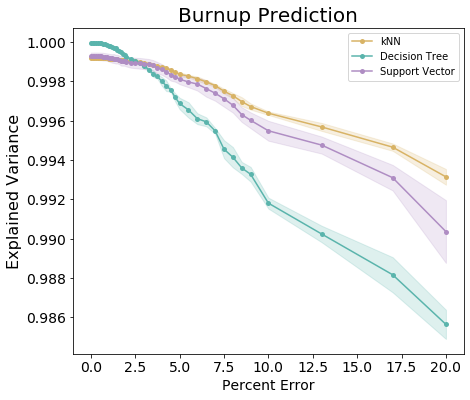

In [12]:
plot_errorcurves(burn)


In [ ]:
plt.clf()
rxtrerr = plot_errorcurves(rxtr)
rxtrerr.savefig('../results/19jan2020_15nuc/graphs/rxtr_error.png', bbox_inches='tight', transparent=True)
